In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import keras.layers

from IPython.display import display
from IPython.display import Markdown

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,f1_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras import datasets
from keras import layers
from keras import optimizers
from keras import models
from keras.utils import np_utils

#monta uma imagem do Google Drive para que o collaboratory possa acessar a base de dados 
#from google.colab import drive
#drive.mount('/content/gdrive')

# Tira os warning do TF
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#INPUT_FILEPATH = "/content/gdrive/My Drive/data.csv"
INPUT_FILEPATH = "data.csv"
TARGET = "label"
n_classes = 2
labels = ['Ruim', 'Bom']

## Dados de Entrada

A base de dados consiste em um conjunto de URLs classificadas em boas e ruins. Ele está disponível em: https://www.kaggle.com/antonyj453/urldataset

In [0]:
df = pd.read_csv(INPUT_FILEPATH)

print("Numero de linhas: {}".format(df.shape[0]))
print("Numero de colunas: {}".format(df.shape[1]))
print("Dados faltando: {}".format(df.isnull().sum().sum()))

print("\nAmostra:")
with pd.option_context("max_columns", 3):
    display(df.head(20))

# Cria uma lista com as features
features = list(df.columns)
features.remove(TARGET)

print("Target: {}".format(TARGET))
print("Features:")
print("\n".join(["  " + x for x in features]))

mpl.rc('font', size=14)

Numero de linhas: 420464
Numero de colunas: 2
Dados faltando: 0

Amostra:


,url,label
0,diaryofagameaddict.com,bad
1,espdesign.com.au,bad
2,iamagameaddict.com,bad
3,kalantzis.net,bad
4,slightlyoffcenter.net,bad
5,toddscarwash.com,bad
6,tubemoviez.com,bad
7,ipl.hk,bad
8,crackspider.us/toolbar/install.php?pack=exe,bad
9,pos-kupang.com/,bad


Target: label
Features:
  url


## Target

In [0]:
with pd.option_context("max_columns", 25):
    display((df[TARGET].value_counts()/len(df)*100).round(2).to_frame(TARGET +" (%)").T)

#cria uma representação binária das classes onde 1 a classe alvo (URLs maliciosas)
df[TARGET] = (df[TARGET] == "bad").astype(int)
with pd.option_context("max_columns", 25):
    display((df[TARGET].value_counts()/len(df)*100).round(2).to_frame(TARGET +" (%)").T)

,good,bad
label (%),82.01,17.99


,0,1
label (%),82.01,17.99


## Pré-processamento

### Partições

In [0]:
#Cria as partições de treino, validação e teste. 
#Desse modo, o modelo treinado só tera acesso à partição de teste no momento de gerar os resultados finais.
x_train, x_test, y_train, y_test = train_test_split(df.url, df.label, test_size=0.2, random_state=0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size= 0.2, random_state=0)

### Tokenização

In [0]:
#cria a representação das URLs em formato de tokens
tokenizer = Tokenizer(char_level=True, lower=False)
tokenizer.fit_on_texts(x_train)

x_train_int = tokenizer.texts_to_sequences(x_train)
x_val_int = tokenizer.texts_to_sequences(x_val)
x_test_int = tokenizer.texts_to_sequences(x_test)

### Padding

In [0]:
#normaliza o tamanho da entrada
max_length = max([len(i) for i in x_train_int])

x_train_int = pad_sequences(x_train_int, padding='post', maxlen=max_length)
x_val_int = pad_sequences(x_val_int, padding='post', maxlen=max_length)
x_test_int = pad_sequences(x_test_int, padding='post', maxlen=max_length)

### Funções auxiliares

In [0]:
def gerar_graficos_treino(history):
    # Gera graficos do resultado do treino
    mpl.rc("font", **{"size": 14})
    fig, axes = plt.subplots(1, 2, figsize=(17, 7))

    # Loss
    axes[0].plot(range(1, len(history.history["loss"])+1), history.history["loss"], 
            label="Train Loss", color="royalblue", lw=3)
    axes[0].plot(range(1, len(history.history["val_loss"])+1), history.history["val_loss"], 
            label="Val Loss", color="forestgreen", lw=3)
    axes[0].set_ylabel("Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_xticks(range(1, len(history.history["acc"])+1, 2))
    axes[0].legend()

    # Accuracy
    axes[1].plot(range(1, len(history.history["acc"])+1), history.history["acc"], 
            label="Train ACC", color="royalblue", lw=3)
    axes[1].plot(range(1, len(history.history["val_acc"])+1), history.history["val_acc"], 
            label="Val ACC", color="forestgreen", lw=3)
    axes[1].set_ylabel("Accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].set_xticks(range(1, len(history.history["acc"])+1, 2))
    axes[1].legend()
    return plt

def gerar_matriz_confusao(y_pred, y_true):
    cm = confusion_matrix(y_true, y_pred)
    classes = list(range(0, 11))
    fig, ax = plt.subplots(figsize=(7, 7))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title="Matriz de Confusão",
           ylabel="Real",
           xlabel="Predito")

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], "d"),
                    ha="center", va="center",
                    color="white" if cm[i, j] > cm.max()/2. else "black")
    fig.tight_layout()
    return plt

## Classificador

In [0]:
def cnn(input_dim):
    # Cria o modelo do Keras usando a API funcional
    model_input = layers.Input(shape= (input_dim,), name="Input")
    
    x = layers.Reshape((input_dim, 1))(model_input)
    # Parte de extração de features: convolução e pooling
    x = layers.Conv1D(32, 2,activation="relu", padding="same", name="Conv1")(x)
    x = layers.Conv1D(32, kernel_size=(2, ), activation="relu", padding="same", name="Conv2")(x)
    x = layers.MaxPooling1D(2,padding='same', name="Pool1")(x)
    x = layers.Dropout(0.25, name="Dropout1")(x)
    
    x = layers.Conv1D(64, 3, activation="relu",padding="same", name="Conv3")(x)
    x = layers.Conv1D(64, kernel_size=(3, ), activation="relu", padding="same", name="Conv4")(x)
    x = layers.MaxPooling1D(2,padding='same', name="Pool2")(x)
    x = layers.Dropout(0.25, name="Dropout2")(x)
    
    # Camada que "achata" para depois usar em camadas fully connected
    x = layers.Flatten(name="Flatten")(x)
    
    # Camada fully connected 
    x = layers.Dense(128, activation="relu", name="Dense1")(x)
    x = layers.Dense(64, activation="relu", name="Dense2")(x)

    # Ultima camada com ativacao softmax, que tem um neurônio como saida
    model_output = layers.Dense(1, activation='sigmoid', name="Output")(x)
    model = models.Model(model_input, model_output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model, model_input


In [0]:
model, model_input = cnn(x_train_int.shape[1])
model.summary()

optimizer = optimizers.Adam(lr=0.01)
early_stopping = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

#utiliza peso 4 para a classe 1 devido ao desbalanceamento do dataset
#tanto configuração quanto a estrutura da rede foram definidos de modo empírico
#a estrutura final da rede clasifica o problema de forma binária
history = model.fit(x_train_int, y_train, batch_size=32, verbose = 2, epochs=30, class_weight= {0: 1., 1: 4.}, validation_split=0.2, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 2307)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 2307, 1)           0         
_________________________________________________________________
Conv1 (Conv1D)               (None, 2307, 32)          96        
_________________________________________________________________
Conv2 (Conv1D)               (None, 2307, 32)          2080      
_________________________________________________________________
Pool1 (MaxPooling1D)         (None, 1154, 32)          0         
_________________________________________________________________
Dropout1 (Dropout)           (None, 1154, 32)          0         
_________________________________________________________________
Conv3 (Conv1D)               (None, 1154, 64)          6208      
__________

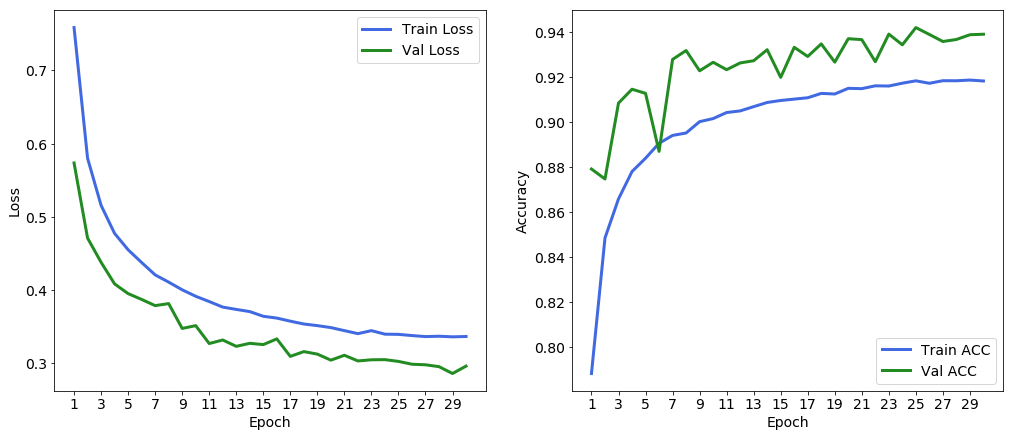

In [0]:
gerar_graficos_treino(history).show()

## Validação

In [0]:
y_proba = model.predict(x_val_int)
y_pred = np.round(y_proba)
y_true = y_val

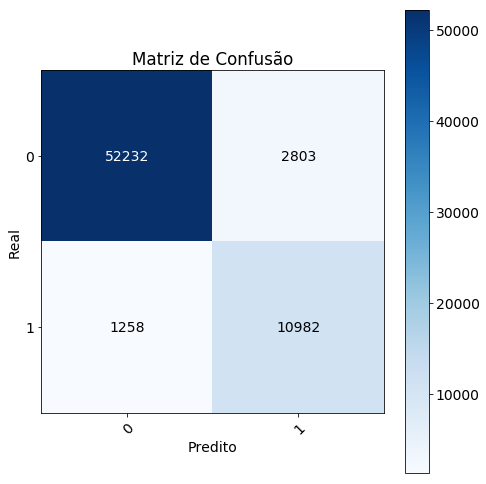

In [0]:
gerar_matriz_confusao(y_pred, y_val).show()

In [0]:
print('\nClassification Report:\n',classification_report(y_val, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96     55035
           1       0.80      0.90      0.84     12240

    accuracy                           0.94     67275
   macro avg       0.89      0.92      0.90     67275
weighted avg       0.94      0.94      0.94     67275



##Teste

In [0]:
y_proba = model.predict(x_test_int)
y_pred = np.round(y_proba)
y_true = y_test

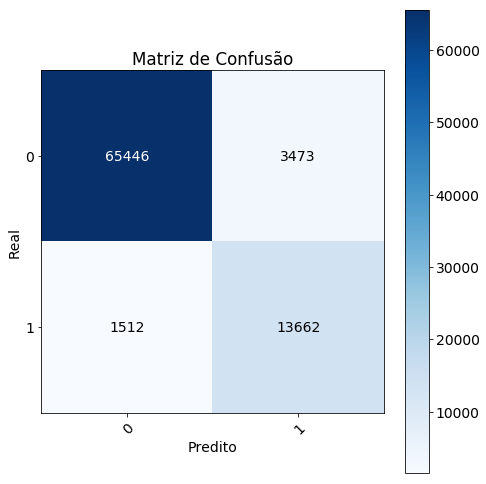

In [0]:
gerar_matriz_confusao(y_pred, y_true).show()

In [0]:
print('\nClassification Report:\n',classification_report(y_true, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96     68919
           1       0.80      0.90      0.85     15174

    accuracy                           0.94     84093
   macro avg       0.89      0.92      0.90     84093
weighted avg       0.94      0.94      0.94     84093

